# **Lab 10.2 Image Captioning**

In [1]:
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
from torch.cuda.amp import GradScaler, autocast

# import clip
from transformers import CLIPProcessor, CLIPModel
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
import datasets
from datasets import load_dataset

from timm.scheduler.cosine_lr import CosineLRScheduler

# from tqdm import tqdm
from tqdm.auto import tqdm
# # from .autonotebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import random
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.manual_seed(4912)
random.seed(4912)
np.random.seed(4912)


In [2]:
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = 16
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [3]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [4]:
def imshow_grid(images, caption, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    num_images = len(images)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20),dpi=300)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i].permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
            ax.imshow(torch.clamp(image,0,1),cmap='gray')
            ax.set_title(caption[i], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off empty subplots
    plt.tight_layout()
    plt.show()

In [ ]:
dataset = load_dataset("jpawan33/fkr30k-image-captioning-dataset",split="train")
dataset= dataset.train_test_split(test_size=0.2)
dataset

Complete the `ImageCaptioningDataset()` function where `__getitem__` returns `{'pixel_values': image.squeeze(), 'labels': torch.tensor(captions.input_ids),'decoder_attention_mask':torch.tensor(decoder_mask)}`. Pad each caption in a batch to have the same size, using -100 for padding.

In [6]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, dataset,tokenizer,feature_extractor=None,split="train", transform=None, target_transform=None):
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        pass


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.unk_token
tokenizer

Use your `ImageCaptioningDataset` to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

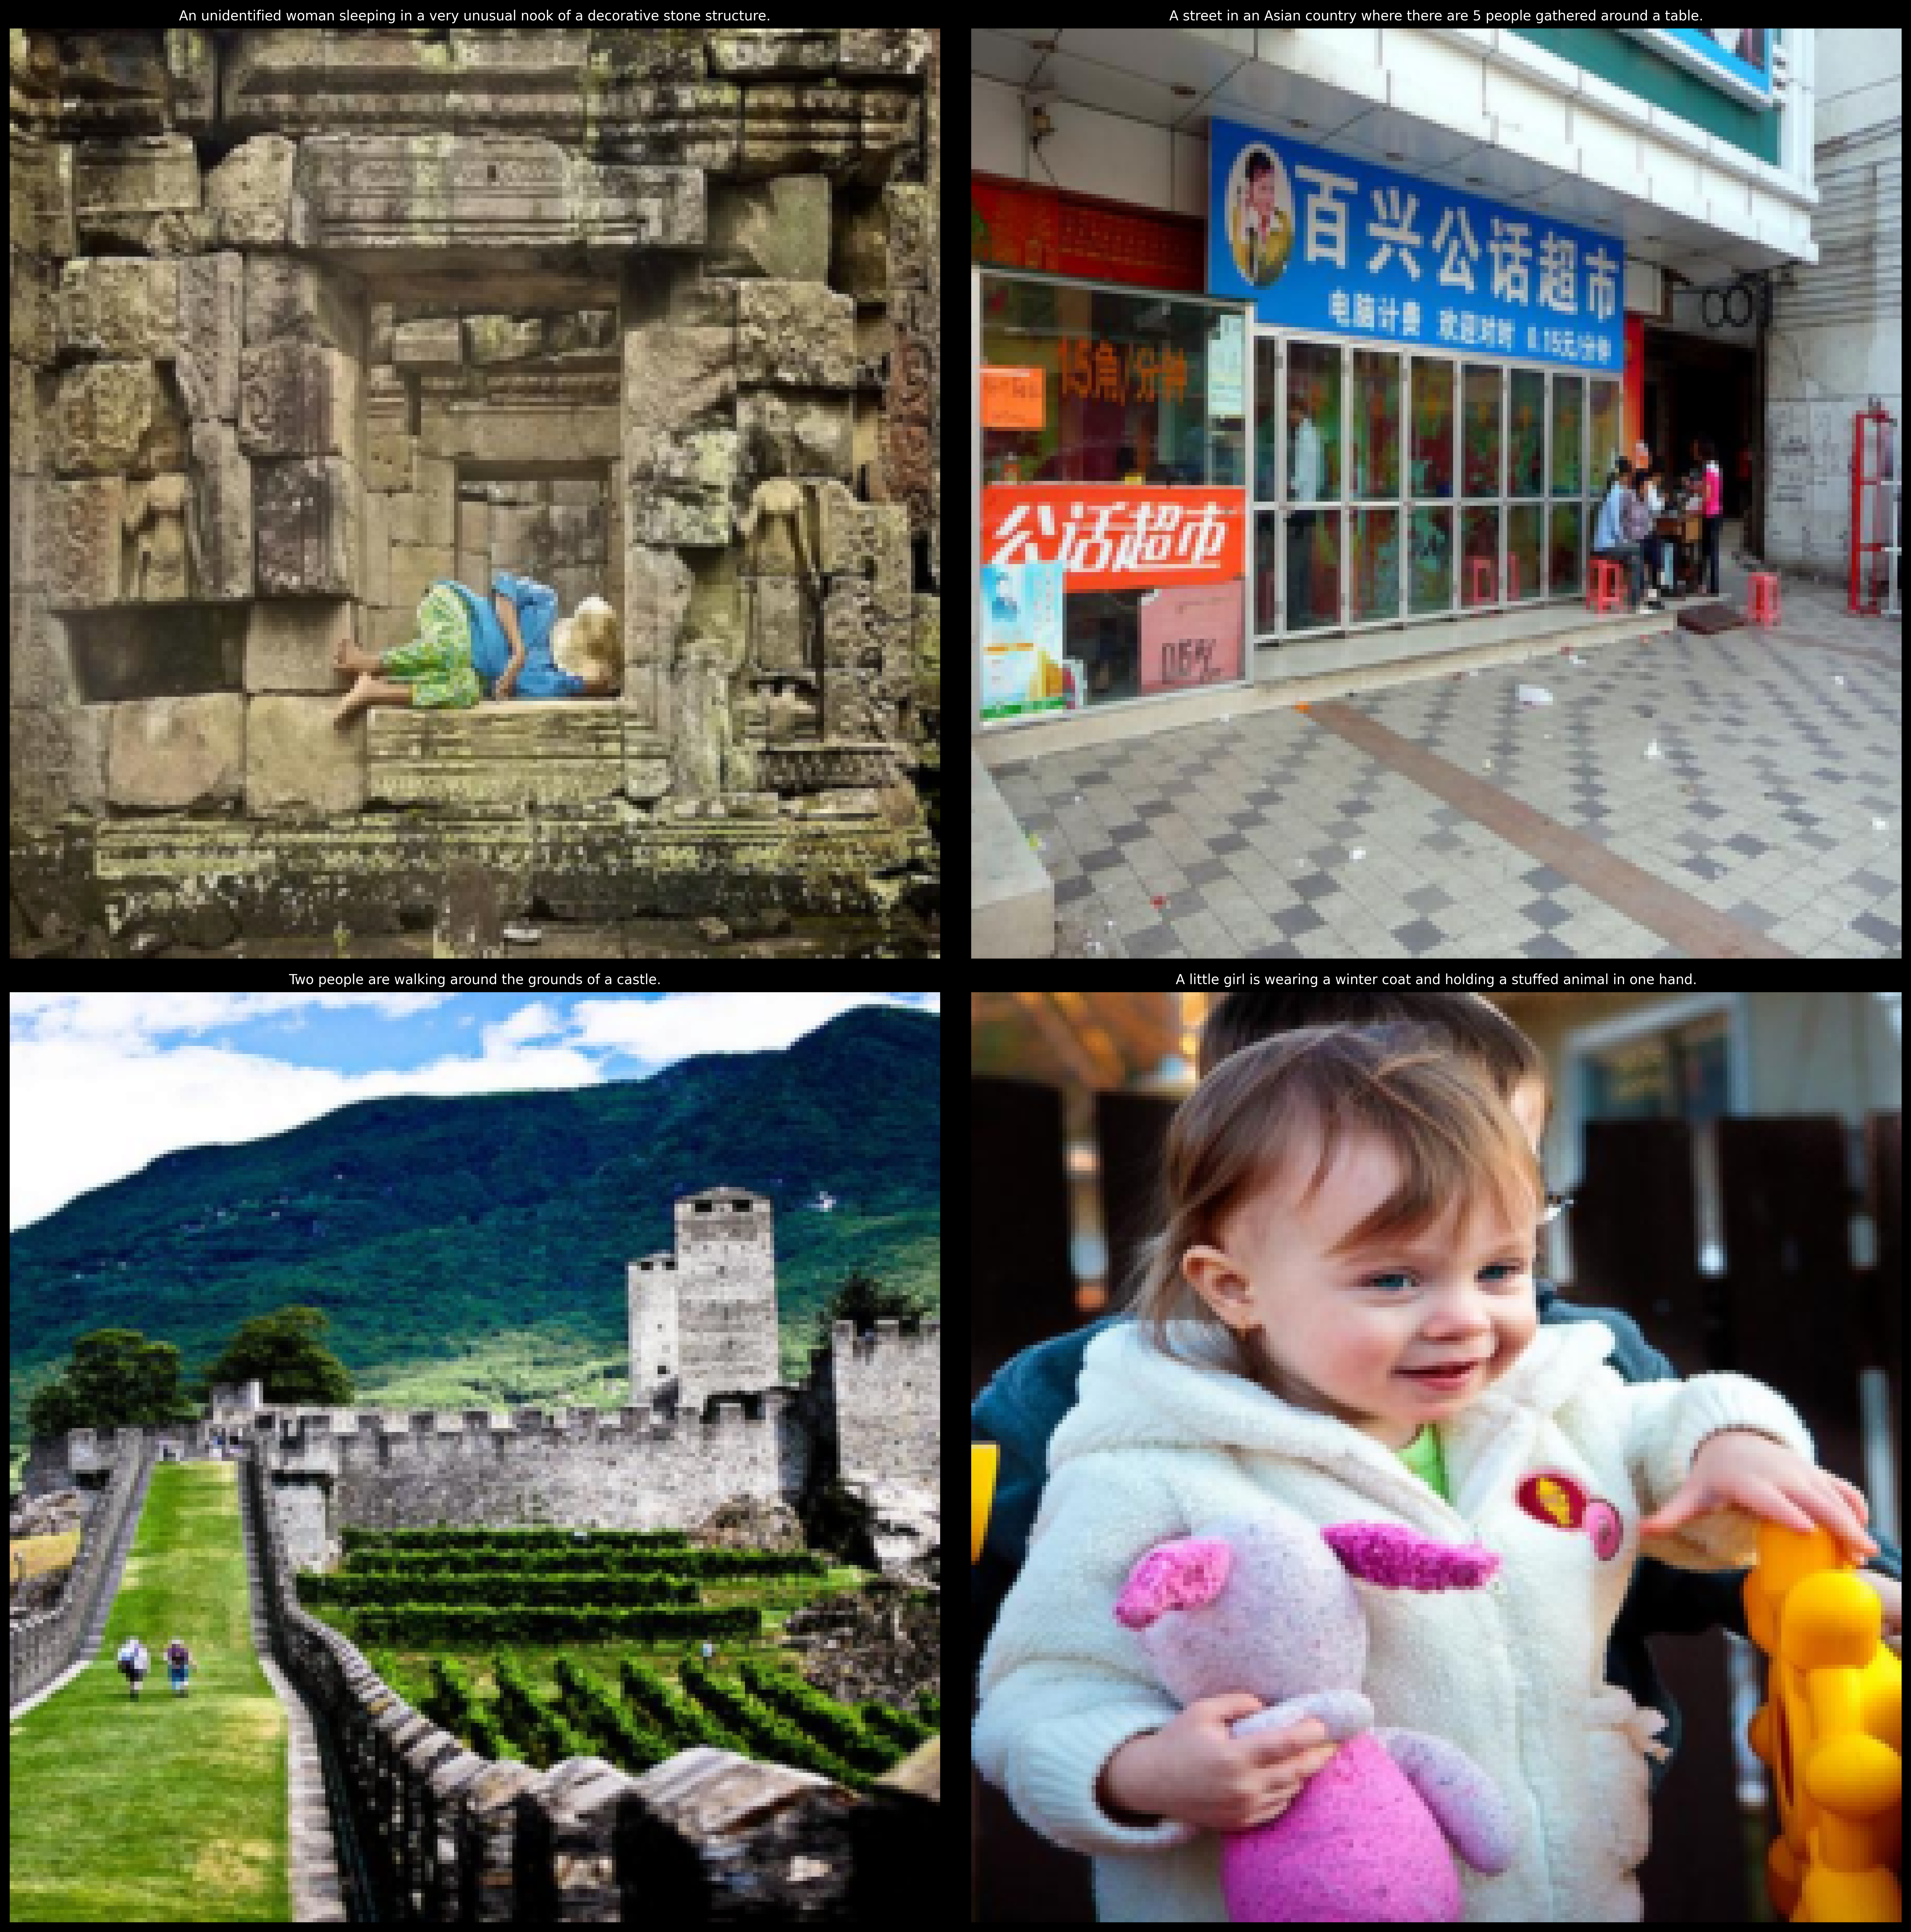

</details>


In [8]:
### START CODE HERE ###


### END CODE HERE ###

Complete the `ImageCaptioningModel()` class below, where the image encoder is a ViT pretrained from PyTorch and the text decoder part is GPT2.
There is some missing piece here, so please complete it.

In [83]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn as nn
### START CODE HERE ###
class ImageCaptioningModel(nn.Module):
    def __init__(self,device='cuda'):
        super(ImageCaptioningModel, self).__init__()
        self.vit = None
        self.vit.head = nn.Identity()
        config = GPT2Config.from_pretrained('gpt2')
        config.add_cross_attention = True
        self.decoder = AutoModelForCausalLM.from_pretrained("gpt2", config=config).to(device)

        self.loss_fct = None
        
        self.vocab_size = None

        self.decoder.config.decoder_start_token_id = tokenizer.cls_token_id
        self.decoder.config.pad_token_id = tokenizer.pad_token_id
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.decoder_start_token_id = tokenizer.bos_token_id
        self.decoder.config.max_length = 128

    def shift_tokens_right(self,input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
        """
        Shift input ids one token to the right.
        """
        shifted_input_ids = input_ids.new_zeros(input_ids.shape)
        shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
        if decoder_start_token_id is None:
            raise ValueError("Make sure to set the decoder_start_token_id attribute of the model's configuration.")
        shifted_input_ids[:, 0] = decoder_start_token_id

        if pad_token_id is None:
            raise ValueError("Make sure to set the pad_token_id attribute of the model's configuration.")

        shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

        return shifted_input_ids

    def forward(self, pixel_values, labels,decoder_attention_mask):
        patch_embeddings = self.vit.None
        n = patch_embeddings.shape[0]
        batch_class_token = None
        patch_embeddings = None
        projected_features = None
        decoder_input_ids = labels 
        decoder_input_ids = self.shift_tokens_right(
                labels, self.decoder.config.pad_token_id, self.decoder.config.decoder_start_token_id
            )
        decoder_outputs = self.decoder(
            None
        )
        loss = self.loss_fct(None)
        return decoder_outputs, loss
    
    def generate_caption(self, pixel_values, max_length=50, device='cuda'):
        pass
### END CODE HERE ###


Complete the `compute_metrics()` function, which computes the rouge-2 score, and the `train_mp()` function, which trains the model with mixed precision using `GradScaler` and `autocast`.

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_metrics(predictions, references,first=False):
    pass

    return {
        "rouge2_precision": None,
        "rouge2_recall": None,
        "rouge2_fmeasure": None,
    }


def train_mp(model, train_dataloader, val_dataloader, epochs, device='cuda'):
    pass
        

Let's train your model. There will be a hidden notice where I will provide a hint with a single keyword: '***cross_attention***'.🤔

In [ ]:
model = ImageCaptioningModel()


In [ ]:

train_mp(None)


Let's test your model.

In [ ]:

print('ground truth:',None  )
print("Generated Caption:", None)

<|endoftext|><|endoftext|>asdfasdfasdfasdf<|endoftext|>

In [24]:
torch.save(model.state_dict(), 'image_captioning_model-tune_all4.pth')

---

Question
1. How do specific regions of the feature map extracted from the image (during encoding) influence particular words or phrases in the captions generated by the decoder ?
2. Give 3 examples of performance metrics and discuss How do these metrics score the model's captions when they exactly match the ground truth versus when they have the same meaning but different wording? Discuss how well each metric captures the overall meaning of captions and the limitations in recognizing semantic accuracy.